In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import networkx as nx

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

from itertools import combinations
from collections import Counter

%matplotlib inline

C:\Users\feder\anaconda3\envs\dataenv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


In [2]:
df = pd.read_csv('data/Bakery sales.csv')

## Data Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [4]:
df.loc[:,'Unnamed: 0']

0              0
1              1
2              4
3              5
4              8
           ...  
234000    511387
234001    511388
234002    511389
234003    511392
234004    511395
Name: Unnamed: 0, Length: 234005, dtype: int64

In [5]:
df = df.drop(columns = 'Unnamed: 0')

### Formatting columns

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  object 
dtypes: float64(2), object(4)
memory usage: 10.7+ MB


In [7]:
df['unit_price']

0         0,90 €
1         1,20 €
2         1,20 €
3         1,15 €
4         1,20 €
           ...  
234000    0,15 €
234001    1,20 €
234002    0,15 €
234003    1,30 €
234004    1,30 €
Name: unit_price, Length: 234005, dtype: object

In [8]:
def convert_currency_format(value):
    value = value.replace('€', '')
    value = value.replace(' ', '')
    value = value.replace(',', '.')
    return float(value)

In [9]:
df['unit_price'] = df['unit_price'].astype(str)
df['unit_price'] = df['unit_price'].apply(convert_currency_format)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   date           234005 non-null  object 
 1   time           234005 non-null  object 
 2   ticket_number  234005 non-null  float64
 3   article        234005 non-null  object 
 4   Quantity       234005 non-null  float64
 5   unit_price     234005 non-null  float64
dtypes: float64(3), object(3)
memory usage: 10.7+ MB


**Renaming 'Quantity' column to 'quantity'**

In [11]:
df = df.rename(columns={'Quantity': 'quantity'})

In [12]:
df.head()

,date,time,ticket_number,article,quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20


#### Converting 'date' and 'time' to the appropiate data type, and creating a new 'datetime' column

In [13]:
df['date'] = df['date'].astype(str)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   date           234005 non-null  datetime64[ns]
 1   time           234005 non-null  object        
 2   ticket_number  234005 non-null  float64       
 3   article        234005 non-null  object        
 4   quantity       234005 non-null  float64       
 5   unit_price     234005 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 10.7+ MB


In [15]:
df.head()

,date,time,ticket_number,article,quantity,unit_price
0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,0.90
1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,1.20
2,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,1.20
3,2021-01-02,09:14,150041.0,PAIN,1.0,1.15
4,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,1.20


In [16]:
df['time'] = df['time'].astype(str)
df['time'] = df['time'] + ':00'

In [17]:
df['time'] = pd.to_timedelta(df['time'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           234005 non-null  datetime64[ns] 
 1   time           234005 non-null  timedelta64[ns]
 2   ticket_number  234005 non-null  float64        
 3   article        234005 non-null  object         
 4   quantity       234005 non-null  float64        
 5   unit_price     234005 non-null  float64        
dtypes: datetime64[ns](1), float64(3), object(1), timedelta64[ns](1)
memory usage: 10.7+ MB


In [19]:
df['datetime'] = df['date'] + df['time']

In [20]:
df.head()

,date,time,ticket_number,article,quantity,unit_price,datetime
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.90,2021-01-02 08:38:00
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00
3,2021-01-02,0 days 09:14:00,150041.0,PAIN,1.0,1.15,2021-01-02 09:14:00
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00


In [21]:
df.describe()

,date,time,ticket_number,quantity,unit_price,datetime
count,234005,234005,234005.000000,234005.000000,234005.000000,234005
mean,2021-11-30 11:33:31.049336576,0 days 11:34:00.873827482,219201.258738,1.538377,1.662195,2021-11-30 23:07:31.923163904
min,2021-01-02 00:00:00,0 days 07:01:00,150040.000000,-200.000000,0.000000,2021-01-02 08:38:00
25%,2021-07-03 00:00:00,0 days 09:42:00,184754.000000,1.000000,1.100000,2021-07-03 11:21:00
50%,2021-11-04 00:00:00,0 days 11:06:00,218807.000000,1.000000,1.200000,2021-11-04 11:56:00
75%,2022-05-31 00:00:00,0 days 12:21:00,253927.000000,2.000000,1.500000,2022-05-31 09:18:00
max,2022-09-30 00:00:00,0 days 20:01:00,288913.000000,200.000000,60.000000,2022-09-30 18:56:00
std,NaN,0 days 02:45:25.077746610,40053.223896,1.289603,1.722720,NaN


The "quantity" column has maximum and minimum values of 200 and -200, so we can suspect there are some extreme values in the column.

C:\Users\feder\anaconda3\envs\dataenv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\feder\anaconda3\envs\dataenv\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


Text(0.5, 1.0, 'Quantity')

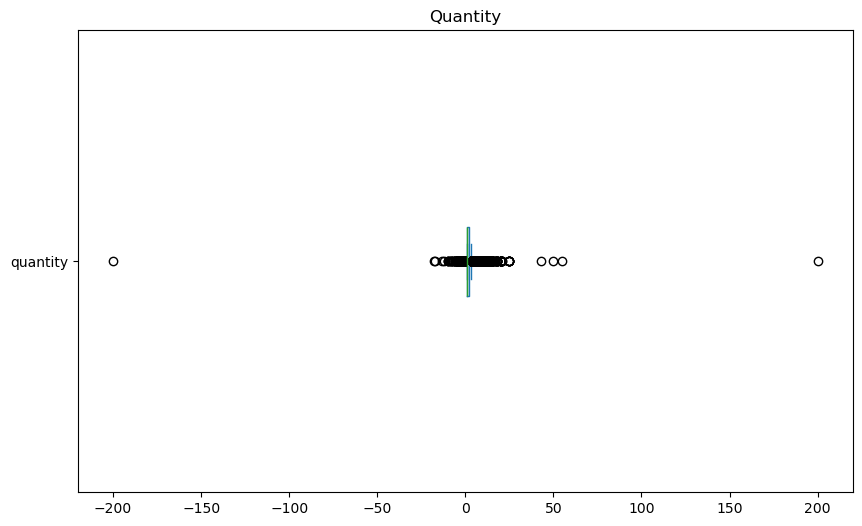

In [22]:
df['quantity'].plot(kind='box', vert=False, figsize=(10,6)).set_title('Quantity')

In [23]:
df[df['quantity'] == 200]

,date,time,ticket_number,article,quantity,unit_price,datetime
50552,2021-06-12,0 days 09:58:00,179931.0,CAFE OU EAU,200.0,1.0,2021-06-12 09:58:00


In [24]:
df[(df['ticket_number'] >= 179931.0) & (df['ticket_number'] < 179933.0)]

,date,time,ticket_number,article,quantity,unit_price,datetime
50552,2021-06-12,0 days 09:58:00,179931.0,CAFE OU EAU,200.0,1.0,2021-06-12 09:58:00
50553,2021-06-12,0 days 09:58:00,179932.0,CAFE OU EAU,-200.0,1.0,2021-06-12 09:58:00


We can observe that this was an error when the quantity was entered, and it was inmediatelly cancelled. These records will be removed from the dataframe.

In [25]:
df = df[(df['quantity'] != 200) & (df['quantity'] != -200)]

Text(0.5, 1.0, 'Quantity')

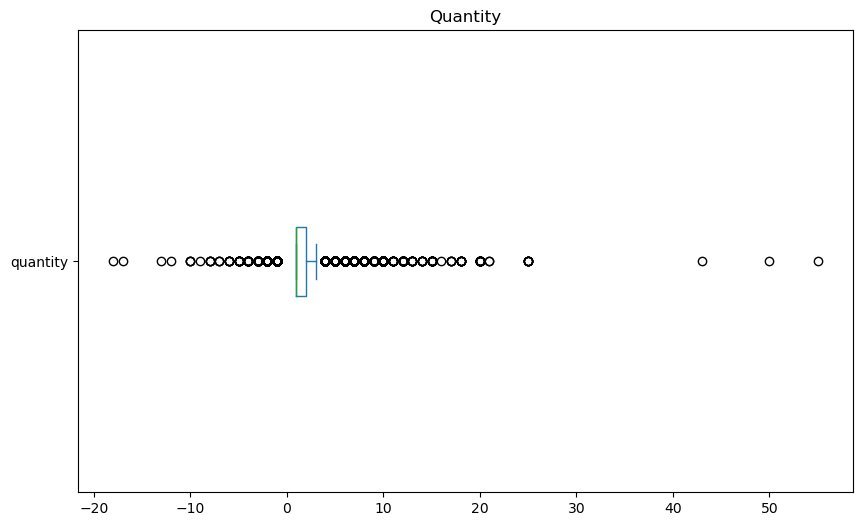

In [26]:
df['quantity'].plot(kind='box', vert=False, figsize=(10,6)).set_title('Quantity')

We still observe values that can be considered outliers, but lets take a closer look first.

In [27]:
df[df['quantity'] > 20]

,date,time,ticket_number,article,quantity,unit_price,datetime
69887,2021-07-23,0 days 11:26:00,191236.0,TARTELETTE,25.0,2.00,2021-07-23 11:26:00
74457,2021-07-30,0 days 17:07:00,193898.0,SEIGLE,25.0,1.80,2021-07-30 17:07:00
74459,2021-07-30,0 days 17:07:00,193898.0,COUPE,25.0,0.15,2021-07-30 17:07:00
89771,2021-08-22,0 days 08:16:00,202518.0,PAIN AU CHOCOLAT,25.0,1.20,2021-08-22 08:16:00
89774,2021-08-22,0 days 08:16:00,202518.0,CROISSANT,25.0,1.10,2021-08-22 08:16:00
111055,2021-10-19,0 days 16:43:00,215345.0,TRADITIONAL BAGUETTE,25.0,1.20,2021-10-19 16:43:00
115245,2021-10-31,0 days 10:42:00,217821.0,TRADITIONAL BAGUETTE,55.0,1.20,2021-10-31 10:42:00
118313,2021-11-08,0 days 10:03:00,219600.0,CAMPAGNE,21.0,1.80,2021-11-08 10:03:00
118314,2021-11-08,0 days 10:03:00,219600.0,COUPE,21.0,0.15,2021-11-08 10:03:00
118315,2021-11-08,0 days 10:03:00,219600.0,BAGUETTE,43.0,0.90,2021-11-08 10:03:00


These seem to be big quantities, but they are reasonable. For example the biggest quantity now is 50, of *PAIN* (bread in English). This could be a customer buying 50 breads for a party or family reunion.

### Checking for duplicates

In [28]:
df.duplicated().sum()

1210

In [29]:
df[df.duplicated(keep=False)]

,date,time,ticket_number,article,quantity,unit_price,datetime
34,2021-01-02,0 days 10:12:00,150061.0,COUPE,1.0,0.15,2021-01-02 10:12:00
36,2021-01-02,0 days 10:12:00,150061.0,COUPE,1.0,0.15,2021-01-02 10:12:00
40,2021-01-02,0 days 10:18:00,150063.0,COUPE,1.0,0.15,2021-01-02 10:18:00
43,2021-01-02,0 days 10:18:00,150063.0,COUPE,1.0,0.15,2021-01-02 10:18:00
218,2021-01-02,0 days 12:23:00,150154.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-02 12:23:00
...,...,...,...,...,...,...,...
233675,2022-09-30,0 days 07:49:00,288719.0,COUPE,1.0,0.15,2022-09-30 07:49:00
233743,2022-09-30,0 days 09:45:00,288757.0,COUPE,1.0,0.15,2022-09-30 09:45:00
233744,2022-09-30,0 days 09:45:00,288757.0,COUPE,1.0,0.15,2022-09-30 09:45:00
233927,2022-09-30,0 days 16:02:00,288867.0,COUPE,1.0,0.15,2022-09-30 16:02:00


1210 duplicates were found, these can be the result of wrong entries by the cashiers or just the same products being marked separately in a purchase. 
These rows will not be removed, let's assume these are products marked separately, since this is a pretty usual thing to happen in stores. 

### Addressing negative values in the quantity column

In [30]:
df[df['quantity'] < 0]

,date,time,ticket_number,article,quantity,unit_price,datetime
448,2021-01-03,0 days 10:41:00,150265.0,BAGUETTE,-1.0,0.90,2021-01-03 10:41:00
1162,2021-01-05,0 days 19:00:00,150738.0,SPECIAL BREAD,-1.0,2.40,2021-01-05 19:00:00
1163,2021-01-05,0 days 19:00:00,150738.0,DIVERS PATISSERIE,-1.0,6.00,2021-01-05 19:00:00
1164,2021-01-05,0 days 19:00:00,150738.0,DIVERS BOULANGERIE,-1.0,2.00,2021-01-05 19:00:00
1467,2021-01-08,0 days 11:58:00,150941.0,COUPE,-1.0,0.15,2021-01-08 11:58:00
...,...,...,...,...,...,...,...
233054,2022-09-27,0 days 18:03:00,288312.0,COUPE,-2.0,0.15,2022-09-27 18:03:00
233055,2022-09-27,0 days 18:03:00,288312.0,TRADITIONAL BAGUETTE,-1.0,1.30,2022-09-27 18:03:00
233056,2022-09-27,0 days 18:03:00,288312.0,CEREAL BAGUETTE,-3.0,1.35,2022-09-27 18:03:00
233553,2022-09-29,0 days 11:55:00,288639.0,BOISSON 33CL,-1.0,1.50,2022-09-29 11:55:00


Negative values in the quantity column were found, this can mean that these transactions were refunds and product returns. We can take a closer look to this records with negative quantities, for example the one at 2021-01-05, SPECIAL BREAD, DIVERS PATISSERIE, and DIVERS BOULANGERIE, with the ticket number of 150738.0

In [31]:
start_time = pd.Timestamp('2021-01-05' + ' 18:40') 
end_time = pd.Timestamp('2021-01-05' + ' 19:00')

df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]

,date,time,ticket_number,article,quantity,unit_price,datetime
1156,2021-01-05,0 days 18:49:00,150734.0,BANETTE,2.0,1.05,2021-01-05 18:49:00
1157,2021-01-05,0 days 18:49:00,150735.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-05 18:49:00
1158,2021-01-05,0 days 18:51:00,150736.0,TRADITIONAL BAGUETTE,1.0,1.20,2021-01-05 18:51:00
1159,2021-01-05,0 days 18:58:00,150737.0,DIVERS PATISSERIE,1.0,6.00,2021-01-05 18:58:00
1160,2021-01-05,0 days 18:58:00,150737.0,DIVERS BOULANGERIE,1.0,2.00,2021-01-05 18:58:00
1161,2021-01-05,0 days 18:58:00,150737.0,SPECIAL BREAD,1.0,2.40,2021-01-05 18:58:00
1162,2021-01-05,0 days 19:00:00,150738.0,SPECIAL BREAD,-1.0,2.40,2021-01-05 19:00:00
1163,2021-01-05,0 days 19:00:00,150738.0,DIVERS PATISSERIE,-1.0,6.00,2021-01-05 19:00:00
1164,2021-01-05,0 days 19:00:00,150738.0,DIVERS BOULANGERIE,-1.0,2.00,2021-01-05 19:00:00
1165,2021-01-05,0 days 19:00:00,150739.0,DIVERS PATISSERIE,1.0,6.00,2021-01-05 19:00:00


We observe that those same three items were bought a couple of minutes before with the ticket number 150737.0, this shows that these negative numbers may represent, in most cases, returns or cancelled purchases.

For the purposes of the analysis, the rows with negative amounts will be removed alongside their original transactions since the aim of this project is analyzing the sales.

#### Removing cancelled purchases

**Adding a "revenue" column**:

In [32]:
df['revenue'] = df['quantity'] * df['unit_price']

In [33]:
transactions = df.groupby('ticket_number').agg({
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()

transactions = transactions.sort_values(by='ticket_number')
transactions

,ticket_number,quantity,revenue
0,150040.0,4.0,4.50
1,150041.0,3.0,3.55
2,150042.0,5.0,6.00
3,150043.0,5.0,5.10
4,150044.0,1.0,1.05
...,...,...,...
136444,288908.0,2.0,2.70
136445,288910.0,1.0,1.30
136446,288911.0,11.0,12.15
136447,288912.0,1.0,1.30


In [34]:
transactions['prev_ticket'] = transactions['ticket_number'].shift(1)
transactions['prev_quantity'] = transactions['quantity'].shift(1)
transactions['prev_revenue'] = transactions['revenue'].shift(1)

In [35]:
returns = transactions[transactions['quantity'] < 0]
returns

,ticket_number,quantity,revenue,prev_ticket,prev_quantity,prev_revenue
222,150265.0,-1.0,-0.90,150264.0,1.0,0.90
685,150738.0,-3.0,-10.40,150737.0,3.0,10.40
883,150941.0,-8.0,-8.45,150940.0,8.0,8.45
1211,151280.0,-2.0,-2.65,151279.0,2.0,2.65
1406,151476.0,-1.0,-6.50,151475.0,2.0,1.65
...,...,...,...,...,...,...
133338,285716.0,-3.0,-9.60,285715.0,3.0,9.60
134409,286810.0,-2.0,-2.60,286809.0,2.0,2.60
135514,287953.0,-2.0,-1.80,287952.0,2.0,1.80
135866,288312.0,-10.0,-22.55,288311.0,10.0,22.55


In [36]:
returns[returns['ticket_number'] != (returns['prev_ticket'] + 1)]

,ticket_number,quantity,revenue,prev_ticket,prev_quantity,prev_revenue
15460,165805.0,-2.0,-2.20,165802.0,3.0,3.40
78581,229839.0,-2.0,-3.30,229837.0,2.0,3.30
91566,243142.0,-1.0,-1.25,243140.0,1.0,1.25
96525,248247.0,-2.0,-2.05,248245.0,2.0,2.05
97084,248814.0,-2.0,-2.50,248812.0,2.0,2.50
98073,249831.0,-6.0,-7.20,249829.0,6.0,7.20
104160,256034.0,-3.0,-5.00,256032.0,3.0,5.00
107434,259374.0,-4.0,-7.80,259372.0,1.0,1.25
130481,282809.0,-5.0,-28.15,282807.0,5.0,28.15


In [37]:
returns[(returns['quantity'] + returns['prev_quantity']) != 0]

,ticket_number,quantity,revenue,prev_ticket,prev_quantity,prev_revenue
1406,151476.0,-1.0,-6.50,151475.0,2.0,1.65
5066,155227.0,-1.0,-6.50,155226.0,2.0,1.65
7016,157215.0,-7.0,-9.50,157214.0,2.0,2.25
9310,159542.0,-3.0,-3.75,159541.0,2.0,8.20
15460,165805.0,-2.0,-2.20,165802.0,3.0,3.40
16683,167048.0,-2.0,-2.10,167047.0,1.0,1.20
16917,167291.0,-1.0,-1.25,167290.0,3.0,5.25
17035,167410.0,-1.0,-6.50,167409.0,4.0,5.65
19980,170400.0,-1.0,-1.05,170399.0,5.0,9.60
23570,174035.0,-9.0,-10.70,174034.0,4.0,4.80


In [38]:
len(returns[(returns['quantity'] + returns['prev_quantity']) != 0])

44

In [39]:
df[(df['ticket_number'] == 167410.0) | (df['ticket_number'] == 167409.0) | (df['ticket_number'] == 167411.0)]

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue
29150,2021-04-16,0 days 11:53:00,167409.0,ECLAIR,1.0,2.00,2021-04-16 11:53:00,2.00
29151,2021-04-16,0 days 11:53:00,167409.0,BOULE 400G,1.0,1.50,2021-04-16 11:53:00,1.50
29152,2021-04-16,0 days 11:53:00,167409.0,PARIS BREST,1.0,2.00,2021-04-16 11:53:00,2.00
29153,2021-04-16,0 days 11:53:00,167409.0,COUPE,1.0,0.15,2021-04-16 11:53:00,0.15
29154,2021-04-16,0 days 11:54:00,167410.0,FORMULE SANDWICH,-1.0,6.50,2021-04-16 11:54:00,-6.50
29155,2021-04-16,0 days 11:55:00,167411.0,FORMULE SANDWICH,1.0,6.50,2021-04-16 11:55:00,6.50


In [40]:
returns = returns[(returns['quantity'] + returns['prev_quantity']) == 0]
len(returns)

722

In [41]:
tickets_to_remove = returns['ticket_number'].to_list() + returns['prev_ticket'].to_list()

In [42]:
len(tickets_to_remove)

1444

In [43]:
sales_data = df.copy()

In [44]:
sales_data = sales_data[~sales_data['ticket_number'].isin(tickets_to_remove)]
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231612 entries, 0 to 234004
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           231612 non-null  datetime64[ns] 
 1   time           231612 non-null  timedelta64[ns]
 2   ticket_number  231612 non-null  float64        
 3   article        231612 non-null  object         
 4   quantity       231612 non-null  float64        
 5   unit_price     231612 non-null  float64        
 6   datetime       231612 non-null  datetime64[ns] 
 7   revenue        231612 non-null  float64        
dtypes: datetime64[ns](2), float64(4), object(1), timedelta64[ns](1)
memory usage: 15.9+ MB


In [45]:
sales_data.describe()

,date,time,ticket_number,quantity,unit_price,datetime,revenue
count,231612,231612,231612.000000,231612.000000,231612.000000,231612,231612.000000
mean,2021-11-30 03:32:15.878969856,0 days 11:33:46.972436661,219143.005142,1.554272,1.658170,2021-11-30 15:06:02.851406848,2.412097
min,2021-01-02 00:00:00,0 days 07:01:00,150040.000000,-10.000000,0.000000,2021-01-02 08:38:00,-21.000000
25%,2021-07-03 00:00:00,0 days 09:42:00,184696.750000,1.000000,1.100000,2021-07-03 10:08:45,1.200000
50%,2021-11-03 00:00:00,0 days 11:06:00,218546.500000,1.000000,1.200000,2021-11-03 10:09:30,1.600000
75%,2022-05-31 00:00:00,0 days 12:21:00,254001.250000,2.000000,1.500000,2022-05-31 11:28:00,2.600000
max,2022-09-30 00:00:00,0 days 20:01:00,288913.000000,55.000000,60.000000,2022-09-30 18:56:00,121.000000
std,NaN,0 days 02:45:15.531058639,40078.296728,1.126488,1.715539,NaN,2.532546


In [46]:
sales_data[sales_data['quantity'] < 0]

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue
1845,2021-01-09,0 days 13:23:00,151163.0,FORMULE SANDWICH,-1.0,6.50,2021-01-09 13:23:00,-6.50
2351,2021-01-11,0 days 12:31:00,151476.0,FORMULE SANDWICH,-1.0,6.50,2021-01-11 12:31:00,-6.50
8463,2021-02-09,0 days 13:41:00,155227.0,FORMULE SANDWICH,-1.0,6.50,2021-02-09 13:41:00,-6.50
11892,2021-02-23,0 days 09:25:00,157215.0,CROISSANT,-1.0,1.10,2021-02-23 09:25:00,-1.10
11893,2021-02-23,0 days 09:25:00,157215.0,PAIN CHOCO AMANDES,-2.0,1.50,2021-02-23 09:25:00,-3.00
...,...,...,...,...,...,...,...,...
218187,2022-08-19,0 days 16:13:00,279309.0,COUPE,-1.0,0.15,2022-08-19 16:13:00,-0.15
218188,2022-08-19,0 days 16:13:00,279309.0,VIK BREAD,-1.0,2.70,2022-08-19 16:13:00,-2.70
218189,2022-08-19,0 days 16:13:00,279309.0,PAIN CHOCO AMANDES,-2.0,1.70,2022-08-19 16:13:00,-3.40
226377,2022-09-06,0 days 09:51:00,284218.0,BAGUETTE,-1.0,1.00,2022-09-06 09:51:00,-1.00


In [47]:
sales_data = sales_data[sales_data['quantity'] > 0]
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231514 entries, 0 to 234004
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           231514 non-null  datetime64[ns] 
 1   time           231514 non-null  timedelta64[ns]
 2   ticket_number  231514 non-null  float64        
 3   article        231514 non-null  object         
 4   quantity       231514 non-null  float64        
 5   unit_price     231514 non-null  float64        
 6   datetime       231514 non-null  datetime64[ns] 
 7   revenue        231514 non-null  float64        
dtypes: datetime64[ns](2), float64(4), object(1), timedelta64[ns](1)
memory usage: 15.9+ MB


In [48]:
sales_data.describe()

,date,time,ticket_number,quantity,unit_price,datetime,revenue
count,231514,231514,231514.000000,231514.000000,231514.000000,231514,231514.000000
mean,2021-11-30 03:26:25.241497088,0 days 11:33:46.030304862,219142.868479,1.555664,1.657530,2021-11-30 15:00:11.271801856,2.414959
min,2021-01-02 00:00:00,0 days 07:01:00,150040.000000,1.000000,0.000000,2021-01-02 08:38:00,0.000000
25%,2021-07-03 00:00:00,0 days 09:42:00,184696.000000,1.000000,1.100000,2021-07-03 10:08:00,1.200000
50%,2021-11-03 00:00:00,0 days 11:06:00,218543.000000,1.000000,1.200000,2021-11-03 10:07:00,1.600000
75%,2022-05-31 00:00:00,0 days 12:21:00,254008.000000,2.000000,1.500000,2022-05-31 11:35:00,2.600000
max,2022-09-30 00:00:00,0 days 20:01:00,288913.000000,55.000000,60.000000,2022-09-30 18:56:00,121.000000
std,NaN,0 days 02:45:14.804613599,40079.527282,1.124283,1.714644,NaN,2.528111


### Checking article names

In [49]:
sorted(sales_data['article'].unique())

['.',
 '12 MACARON',
 'ARMORICAIN',
 'ARTICLE 295',
 'BAGUETTE',
 'BAGUETTE APERO',
 'BAGUETTE GRAINE',
 'BANETTE',
 'BANETTINE',
 'BOISSON 33CL',
 'BOTTEREAU',
 'BOULE 200G',
 'BOULE 400G',
 'BOULE POLKA',
 'BRIOCHE',
 'BRIOCHE DE NOEL',
 'BRIOCHETTE',
 'BROWNIES',
 'BUCHE 4PERS',
 'BUCHE 6PERS',
 'BUCHE 8PERS',
 'CAFE OU EAU',
 'CAKE',
 'CAMPAGNE',
 'CARAMEL NOIX',
 'CEREAL BAGUETTE',
 'CHAUSSON AUX POMMES',
 'CHOCOLAT',
 'CHOU CHANTILLY',
 'COMPLET',
 'COOKIE',
 'COUPE',
 'CROISSANT',
 'CROISSANT AMANDES',
 'CRUMBLE',
 'CRUMBLECARAMEL OU PISTAE',
 'DELICETROPICAL',
 'DEMI BAGUETTE',
 'DEMI PAIN',
 'DIVERS BOISSONS',
 'DIVERS BOULANGERIE',
 'DIVERS CONFISERIE',
 'DIVERS PATISSERIE',
 'DIVERS SANDWICHS',
 'DIVERS VIENNOISERIE',
 'DOUCEUR D HIVER',
 'ECLAIR',
 'ECLAIR FRAISE PISTACHE',
 'ENTREMETS',
 'FICELLE',
 'FINANCIER',
 'FINANCIER X5',
 'FLAN',
 'FLAN ABRICOT',
 'FONDANT CHOCOLAT',
 'FORMULE PATE',
 'FORMULE PLAT PREPARE',
 'FORMULE SANDWICH',
 'FRAISIER',
 'FRAMBOISIER',
 'GACHE

# Analysis

In [50]:
sales_data.head()

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.90,2021-01-02 08:38:00,0.90
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00,3.60
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00,2.40
3,2021-01-02,0 days 09:14:00,150041.0,PAIN,1.0,1.15,2021-01-02 09:14:00,1.15
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00,6.00


## Total sales

In [51]:
total_sales = sales_data['revenue'].sum()
total_sales

559096.85

## Sales Over Time

In [52]:
sales_data['month'] = sales_data['datetime'].dt.to_period('M')

In [53]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231514 entries, 0 to 234004
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype          
---  ------         --------------   -----          
 0   date           231514 non-null  datetime64[ns] 
 1   time           231514 non-null  timedelta64[ns]
 2   ticket_number  231514 non-null  float64        
 3   article        231514 non-null  object         
 4   quantity       231514 non-null  float64        
 5   unit_price     231514 non-null  float64        
 6   datetime       231514 non-null  datetime64[ns] 
 7   revenue        231514 non-null  float64        
 8   month          231514 non-null  period[M]      
dtypes: datetime64[ns](2), float64(4), object(1), period[M](1), timedelta64[ns](1)
memory usage: 17.7+ MB


In [54]:
sales_over_time = sales_data.groupby('date')['revenue'].sum().reset_index()
sales_over_time

,date,revenue
0,2021-01-02,987.85
1,2021-01-03,1014.30
2,2021-01-04,461.90
3,2021-01-05,515.70
4,2021-01-07,544.00
...,...,...
595,2022-09-26,693.75
596,2022-09-27,746.45
597,2022-09-28,610.70
598,2022-09-29,689.20


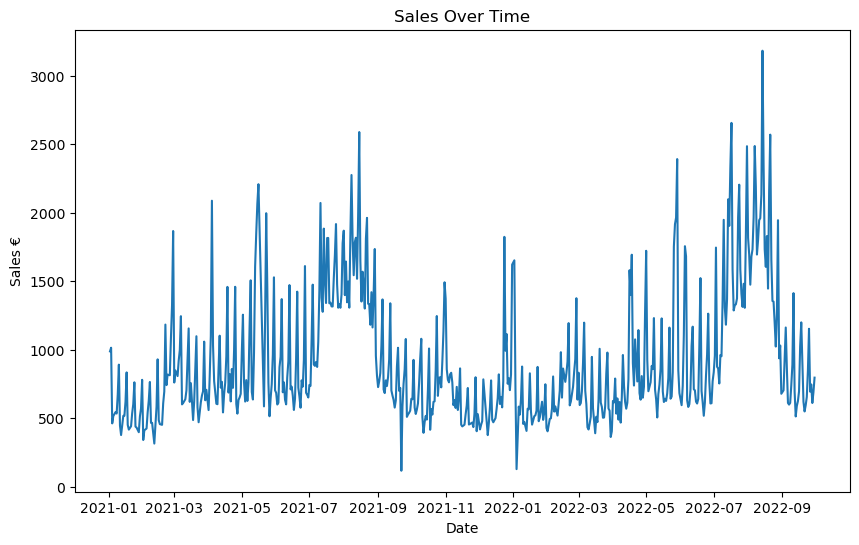

In [55]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_over_time, x='date', y='revenue')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales €')
plt.show()

### Sales by Month

In [56]:
sales_by_month = sales_data.groupby('month')['revenue'].sum().reset_index()
sales_by_month

,month,revenue
0,2021-01,15271.67
1,2021-02,16843.15
2,2021-03,20091.35
3,2021-04,24669.05
4,2021-05,29629.10
5,2021-06,24628.85
6,2021-07,42224.85
7,2021-08,48697.05
8,2021-09,22728.80
9,2021-10,22709.65


In [57]:
sales_by_month['month'] = sales_by_month['month'].dt.strftime('%b %Y')

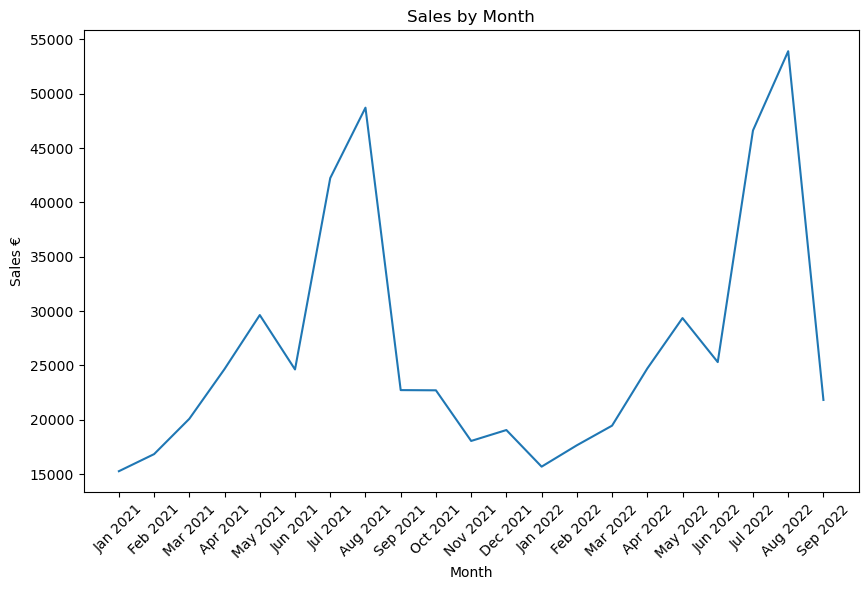

In [58]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_by_month, x='month', y='revenue')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales €')
plt.xticks(rotation=45)
plt.show()

### Sales by Day of Week

In [59]:
sales_data['day_of_week'] = sales_data['date'].dt.dayofweek

day_names = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
             4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

sales_data['day_name'] = sales_data['day_of_week'].map(day_names)

In [60]:
sales_by_day = sales_data.groupby('day_name')['revenue'].sum().reset_index()
sales_by_day

,day_name,revenue
0,Friday,77165.42
1,Monday,74023.05
2,Saturday,93774.12
3,Sunday,126341.08
4,Thursday,70258.13
5,Tuesday,67373.40
6,Wednesday,50161.65


In [61]:
sales_by_day['day_name'] = pd.Categorical(sales_by_day['day_name'], 
                                          categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                                      'Friday', 'Saturday', 'Sunday'], 
                                          ordered=True)
sales_by_day = sales_by_day.sort_values('day_name')

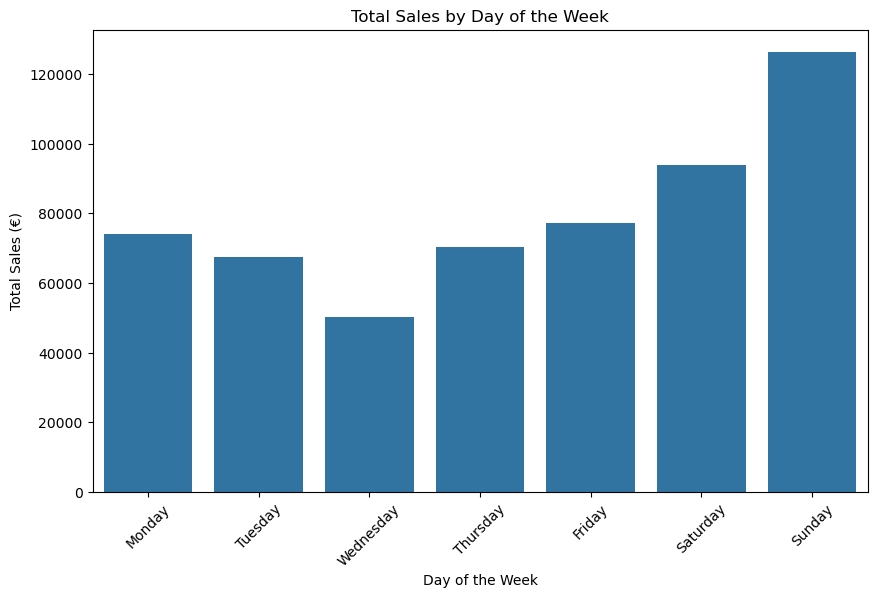

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(data=sales_by_day, x='day_name', y='revenue')
plt.title('Total Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales (€)')
plt.xticks(rotation=45)
plt.show()

In [63]:
sales_data['hour'] = sales_data['datetime'].dt.hour
df.head()

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue
0,2021-01-02,0 days 08:38:00,150040.0,BAGUETTE,1.0,0.90,2021-01-02 08:38:00,0.90
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00,3.60
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00,2.40
3,2021-01-02,0 days 09:14:00,150041.0,PAIN,1.0,1.15,2021-01-02 09:14:00,1.15
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00,6.00


In [64]:
sales_by_hour = sales_data.groupby('hour')['revenue'].sum().reset_index()
sales_by_hour

,hour,revenue
0,7,18031.45
1,8,67850.80
2,9,80577.50
3,10,95191.20
4,11,111578.76
5,12,100947.60
6,13,17816.77
7,14,623.90
8,15,214.60
9,16,19000.17


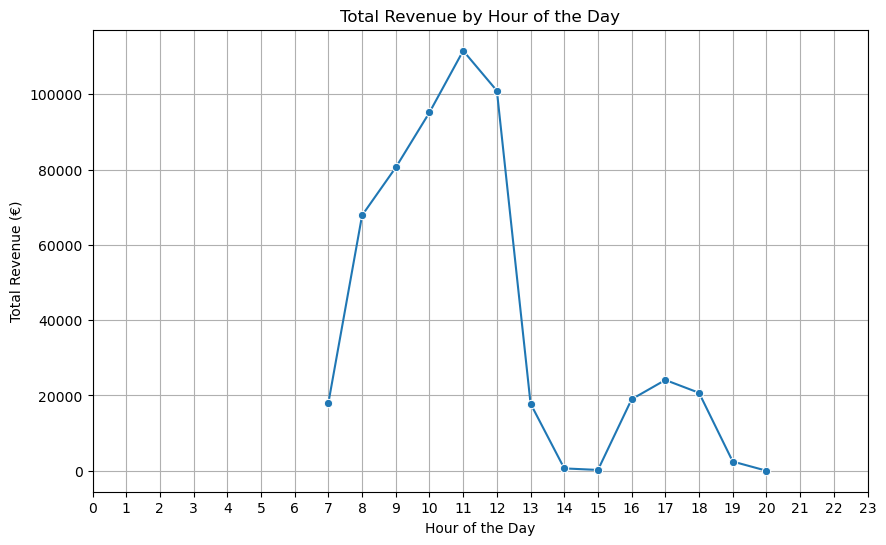

In [65]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=sales_by_hour, x='hour', y='revenue', marker='o')
plt.title('Total Revenue by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Revenue (€)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

In [66]:
avg_revenue_hour = sales_data.groupby('hour')['revenue'].mean().reset_index()
avg_revenue_hour

,hour,revenue
0,7,2.551139
1,8,2.438396
2,9,2.351529
3,10,2.271324
4,11,2.392187
5,12,2.764779
6,13,2.829855
7,14,3.372432
8,15,2.258947
9,16,2.240850


## Best selling products

In [67]:
sales_by_product = sales_data.groupby('article').agg({
    'revenue': 'sum',
    'quantity': 'sum'
}).reset_index().set_index('article').sort_values(by='revenue', ascending=False)
total_revenue = sales_data['revenue'].sum()
sales_by_product['revenue_contribution'] = (sales_by_product['revenue'] / total_revenue) * 100

### Top 10 best selling products

In [68]:
sales_by_product.head(10)

,revenue,quantity,revenue_contribution
article,,,
TRADITIONAL BAGUETTE,144795.20,117495.0,25.898053
FORMULE SANDWICH,34936.50,5214.0,6.248738
CROISSANT,33602.10,29674.0,6.010068
PAIN AU CHOCOLAT,31121.40,25253.0,5.566370
BANETTE,24560.45,22737.0,4.392879
BAGUETTE,20488.95,22061.0,3.664651
SANDWICH COMPLET,13559.50,2890.0,2.425251
SPECIAL BREAD,13422.20,5457.0,2.400693
TRAITEUR,12269.50,1457.0,2.194521


<Axes: title={'center': 'Top 10 best selling products'}, xlabel='article'>

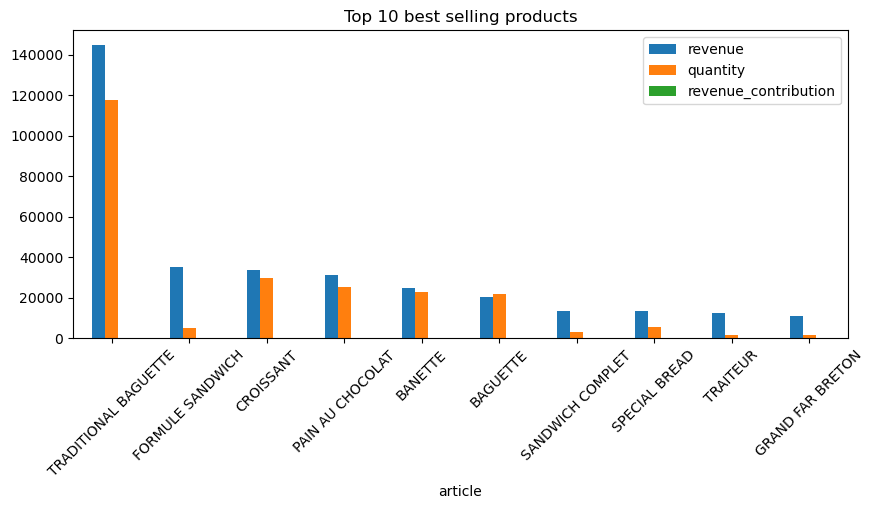

In [69]:
sales_by_product.head(10).plot(kind="bar", figsize=(10,4),title="Top 10 best selling products", rot=45)

In [70]:
top_10 = sales_by_product.head(10)

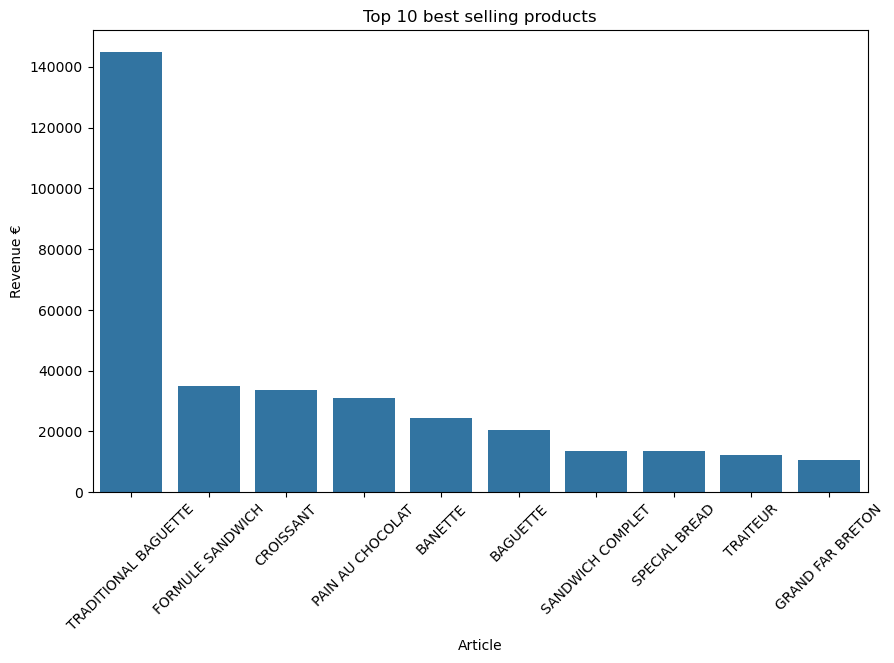

In [71]:
plt.figure(figsize=(10,6))
sns.barplot(data=top_10, x='article', y='revenue')
plt.title('Top 10 best selling products')
plt.xlabel('Article')
plt.ylabel('Revenue €')
plt.xticks(rotation=45)
plt.show()

By seeing the top 10 best selling products, it's clear that the "Traditional Baguette" is by far the best selling product with more than 140,000 Euros in sales, followed by the "Formule Sandwich" with total sales of 34710.50 Euros.

## Top products by quantity sold

### Top 10 products by quantity sold

In [72]:
top_ten_quantity = sales_by_product.quantity.to_frame().sort_values(by='quantity', ascending=False).head(10)
top_ten_quantity

,quantity
article,
TRADITIONAL BAGUETTE,117495.0
CROISSANT,29674.0
PAIN AU CHOCOLAT,25253.0
COUPE,23509.0
BANETTE,22737.0
BAGUETTE,22061.0
CEREAL BAGUETTE,7436.0
SPECIAL BREAD,5457.0
FORMULE SANDWICH,5214.0


<Axes: title={'center': 'Top 10 products by quantity'}, xlabel='article'>

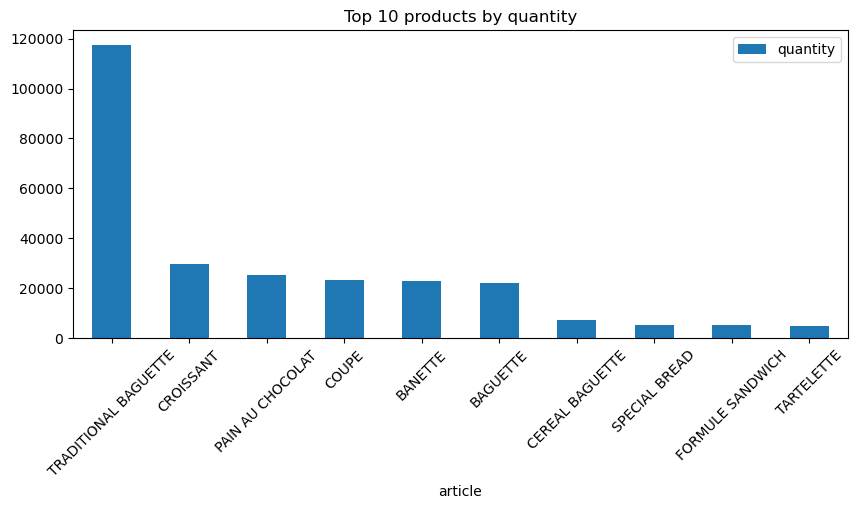

In [73]:
top_ten_quantity.plot(kind="bar", figsize=(10,4),title="Top 10 products by quantity", rot=45)

When it comes to quantity sold, "Traditional Baguettes" is still on top with 117,463 units sold, followed by the "Croissant" with 29,654 units.

## Low-Performing Products

In [74]:
lowest_sales = sales_by_product.sort_values(by='revenue')

In [75]:
lowest_sales.head(20)

,revenue,quantity,revenue_contribution
article,,,
.,0.0,7.0,0.000000
ARTICLE 295,0.0,1.0,0.000000
PAIN NOIR,0.6,1.0,0.000107
DOUCEUR D HIVER,3.0,1.0,0.000537
CAKE,3.0,1.0,0.000537
TROIS CHOCOLAT,3.0,1.0,0.000537
SACHET DE VIENNOISERIE,4.0,1.0,0.000715
PALMIER,6.0,6.0,0.001073
TARTELETTE COCKTAIL,6.0,2.0,0.001073


In [76]:
lowest_quantity = sales_by_product.quantity.to_frame().sort_values(by='quantity')

In [77]:
lowest_quantity.head(20)

,quantity
article,
"PLATPREPARE6,00",1.0
REDUCTION SUCREES 24,1.0
SACHET DE VIENNOISERIE,1.0
DOUCEUR D HIVER,1.0
ARTICLE 295,1.0
CAKE,1.0
PAIN NOIR,1.0
TROIS CHOCOLAT,1.0
TARTELETTE COCKTAIL,2.0


# Analyzing best selling products

In [78]:
best_selling_names = sales_by_product.head(5).index.to_list()
best_selling_names

['TRADITIONAL BAGUETTE',
 'FORMULE SANDWICH',
 'CROISSANT',
 'PAIN AU CHOCOLAT',
 'BANETTE']

In [79]:
best_selling_data = sales_data[sales_data['article'].isin(best_selling_names)]
best_selling_data

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
1,2021-01-02,0 days 08:38:00,150040.0,PAIN AU CHOCOLAT,3.0,1.20,2021-01-02 08:38:00,3.60,2021-01,5,Saturday,8
2,2021-01-02,0 days 09:14:00,150041.0,PAIN AU CHOCOLAT,2.0,1.20,2021-01-02 09:14:00,2.40,2021-01,5,Saturday,9
4,2021-01-02,0 days 09:25:00,150042.0,TRADITIONAL BAGUETTE,5.0,1.20,2021-01-02 09:25:00,6.00,2021-01,5,Saturday,9
6,2021-01-02,0 days 09:25:00,150043.0,CROISSANT,3.0,1.10,2021-01-02 09:25:00,3.30,2021-01,5,Saturday,9
7,2021-01-02,0 days 09:27:00,150044.0,BANETTE,1.0,1.05,2021-01-02 09:27:00,1.05,2021-01,5,Saturday,9
...,...,...,...,...,...,...,...,...,...,...,...,...
233993,2022-09-30,0 days 18:26:00,288905.0,TRADITIONAL BAGUETTE,1.0,1.30,2022-09-30 18:26:00,1.30,2022-09,4,Friday,18
233997,2022-09-30,0 days 18:39:00,288910.0,TRADITIONAL BAGUETTE,1.0,1.30,2022-09-30 18:39:00,1.30,2022-09,4,Friday,18
233999,2022-09-30,0 days 18:52:00,288911.0,TRADITIONAL BAGUETTE,5.0,1.30,2022-09-30 18:52:00,6.50,2022-09,4,Friday,18
234003,2022-09-30,0 days 18:55:00,288912.0,TRADITIONAL BAGUETTE,1.0,1.30,2022-09-30 18:55:00,1.30,2022-09,4,Friday,18


### Sales over time

In [80]:
sales_over_time = best_selling_data.groupby(['date', 'article'])['revenue'].sum().reset_index()
sales_over_time

,date,article,revenue
0,2021-01-02,BANETTE,42.00
1,2021-01-02,CROISSANT,72.60
2,2021-01-02,PAIN AU CHOCOLAT,57.60
3,2021-01-02,TRADITIONAL BAGUETTE,153.60
4,2021-01-03,BANETTE,36.75
...,...,...,...
2935,2022-09-30,BANETTE,34.50
2936,2022-09-30,CROISSANT,45.60
2937,2022-09-30,FORMULE SANDWICH,63.00
2938,2022-09-30,PAIN AU CHOCOLAT,41.60


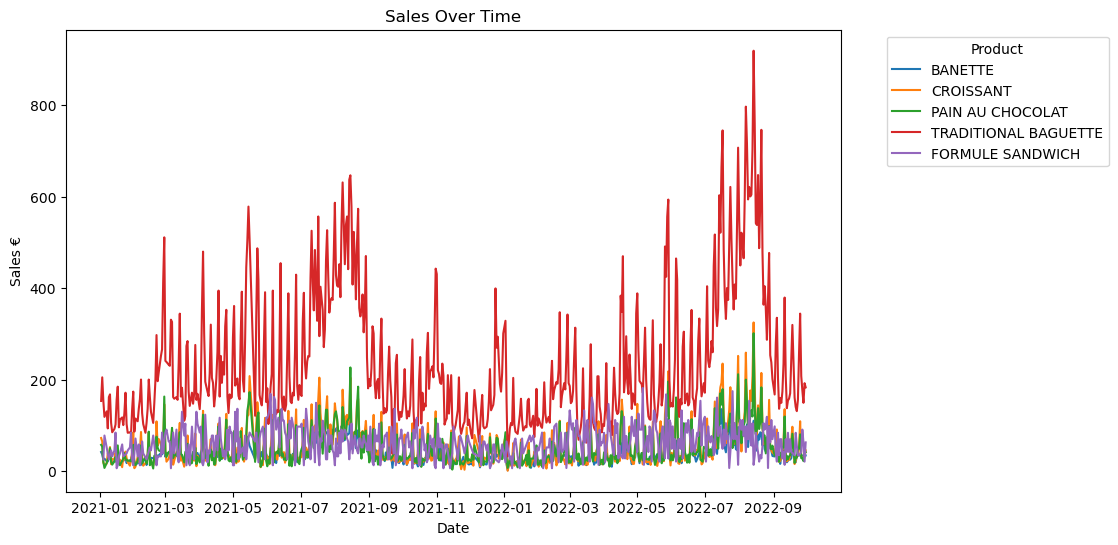

In [81]:
plt.figure(figsize=(10,6))
sns.lineplot(data=sales_over_time, x='date', y='revenue', hue='article')
plt.title('Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales €')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### Sales by month

In [82]:
best_selling_month = best_selling_data.groupby(['month','article']).agg({
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()
best_selling_month

,month,article,quantity,revenue
0,2021-01,BANETTE,649.0,681.45
1,2021-01,CROISSANT,786.0,864.60
2,2021-01,FORMULE SANDWICH,134.0,871.00
3,2021-01,PAIN AU CHOCOLAT,613.0,735.60
4,2021-01,TRADITIONAL BAGUETTE,2751.0,3301.20
...,...,...,...,...
100,2022-09,BANETTE,806.0,926.90
101,2022-09,CROISSANT,1080.0,1296.00
102,2022-09,FORMULE SANDWICH,197.0,1379.00
103,2022-09,PAIN AU CHOCOLAT,928.0,1206.40


In [83]:
best_selling_month['month'] = best_selling_month['month'].dt.strftime('%b %Y')

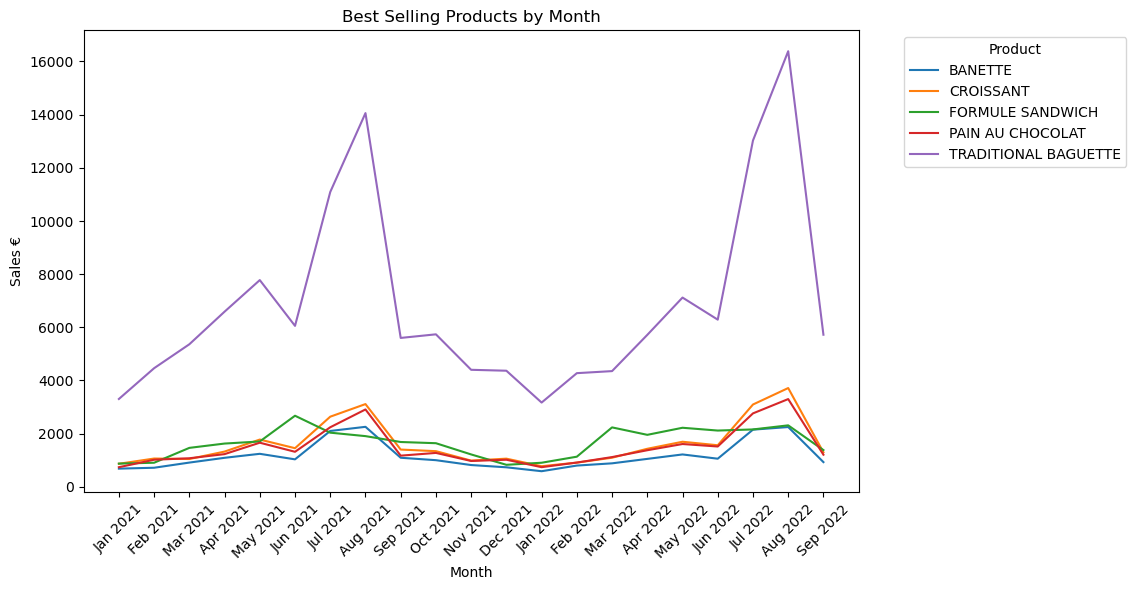

In [84]:
plt.figure(figsize=(10,6))
sns.lineplot(data=best_selling_month, x='month', y='revenue', hue='article')
plt.title('Best Selling Products by Month')
plt.xlabel('Month')
plt.ylabel('Sales €')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

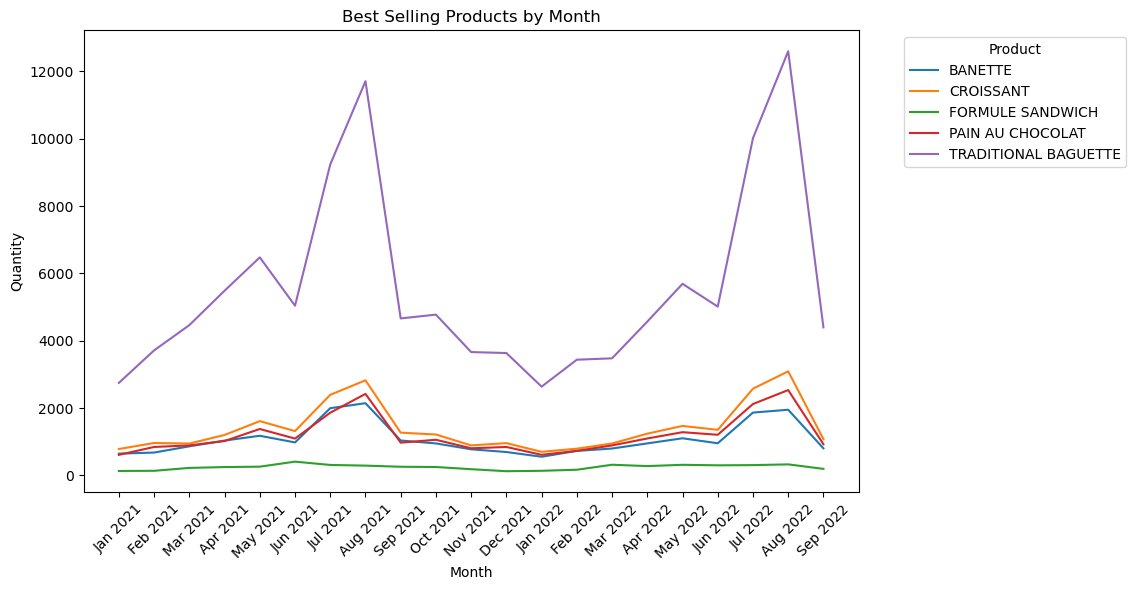

In [85]:
plt.figure(figsize=(10,6))
sns.lineplot(data=best_selling_month, x='month', y='quantity', hue='article')
plt.title('Best Selling Products by Month')
plt.xlabel('Month')
plt.ylabel('Quantity')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [86]:
best_selling_day = best_selling_data.groupby(['day_name', 'article']).agg({
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()
best_selling_day

,day_name,article,quantity,revenue
0,Friday,BANETTE,3056.0,3303.00
1,Friday,CROISSANT,3401.0,3855.75
2,Friday,FORMULE SANDWICH,965.0,6458.00
3,Friday,PAIN AU CHOCOLAT,3357.0,4138.70
4,Friday,TRADITIONAL BAGUETTE,14642.0,18034.80
5,Monday,BANETTE,3156.0,3411.80
6,Monday,CROISSANT,3528.0,4005.80
7,Monday,FORMULE SANDWICH,986.0,6599.50
8,Monday,PAIN AU CHOCOLAT,2977.0,3677.35
9,Monday,TRADITIONAL BAGUETTE,16397.0,20220.30


In [87]:
best_selling_day['day_name'] = pd.Categorical(best_selling_day['day_name'], 
                                          categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                                                      'Friday', 'Saturday', 'Sunday'], 
                                          ordered=True)
best_selling_day = best_selling_day.sort_values('day_name')

In [88]:
best_selling_day.head()

,day_name,article,quantity,revenue
9,Monday,TRADITIONAL BAGUETTE,16397.0,20220.30
5,Monday,BANETTE,3156.0,3411.80
6,Monday,CROISSANT,3528.0,4005.80
7,Monday,FORMULE SANDWICH,986.0,6599.50
8,Monday,PAIN AU CHOCOLAT,2977.0,3677.35


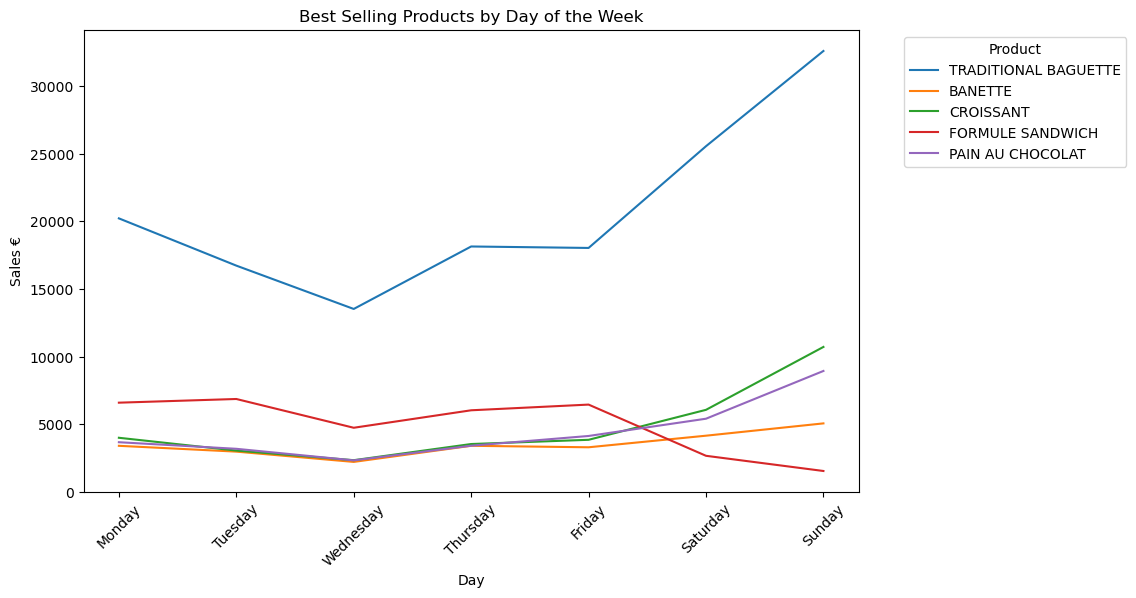

In [89]:
plt.figure(figsize=(10,6))
sns.lineplot(data=best_selling_day, x='day_name', y='revenue', hue='article')
plt.title('Best Selling Products by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Sales €')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

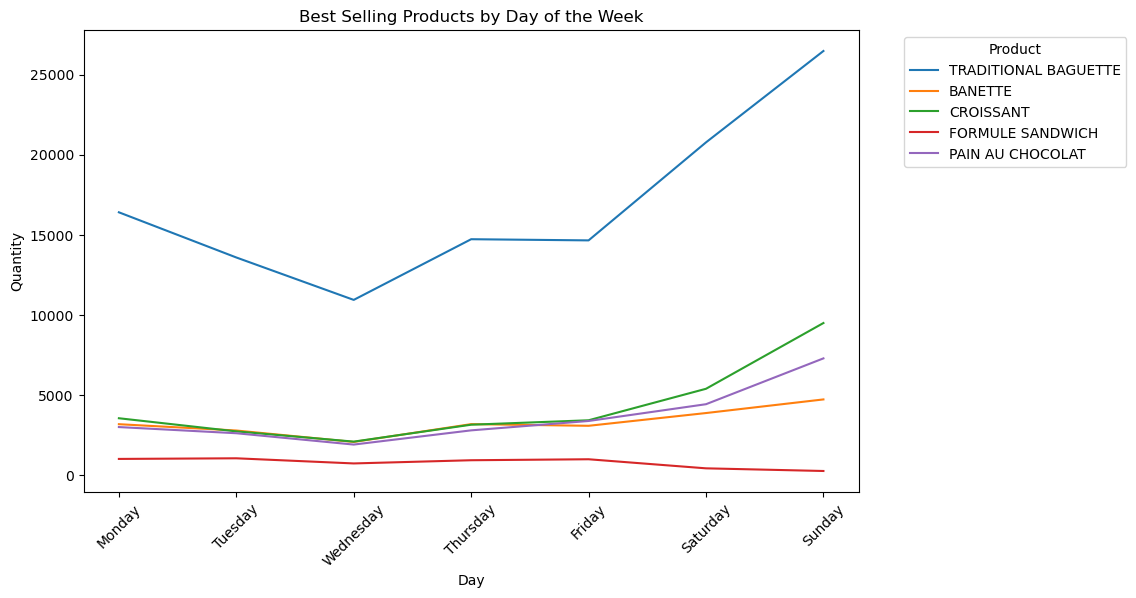

In [90]:
plt.figure(figsize=(10,6))
sns.lineplot(data=best_selling_day, x='day_name', y='quantity', hue='article')
plt.title('Best Selling Products by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Quantity')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [91]:
best_selling_hour = best_selling_data.groupby(['hour', 'article']).agg({
    'quantity': 'sum',
    'revenue': 'sum'
}).reset_index()
best_selling_hour

,hour,article,quantity,revenue
0,7,BANETTE,681.0,745.85
1,7,CROISSANT,3253.0,3711.60
2,7,FORMULE SANDWICH,79.0,526.50
3,7,PAIN AU CHOCOLAT,2788.0,3446.65
4,7,TRADITIONAL BAGUETTE,2554.0,3171.50
...,...,...,...,...
60,19,CROISSANT,28.0,31.75
61,19,FORMULE SANDWICH,5.0,32.50
62,19,PAIN AU CHOCOLAT,27.0,32.65
63,19,TRADITIONAL BAGUETTE,558.0,676.80


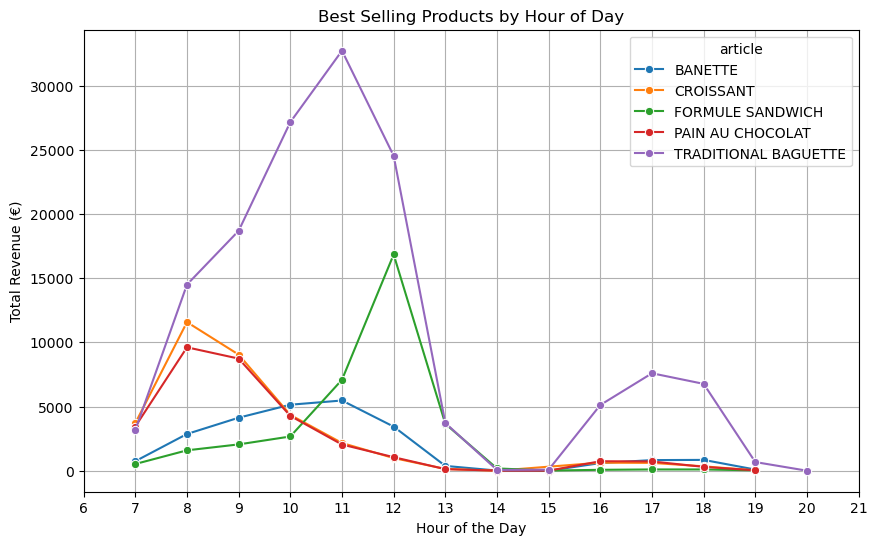

In [92]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=best_selling_hour, x='hour', y='revenue', marker='o', hue='article')
plt.title('Best Selling Products by Hour of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Revenue (€)')
plt.xticks(range(6, 22))
plt.grid(True)
plt.show()

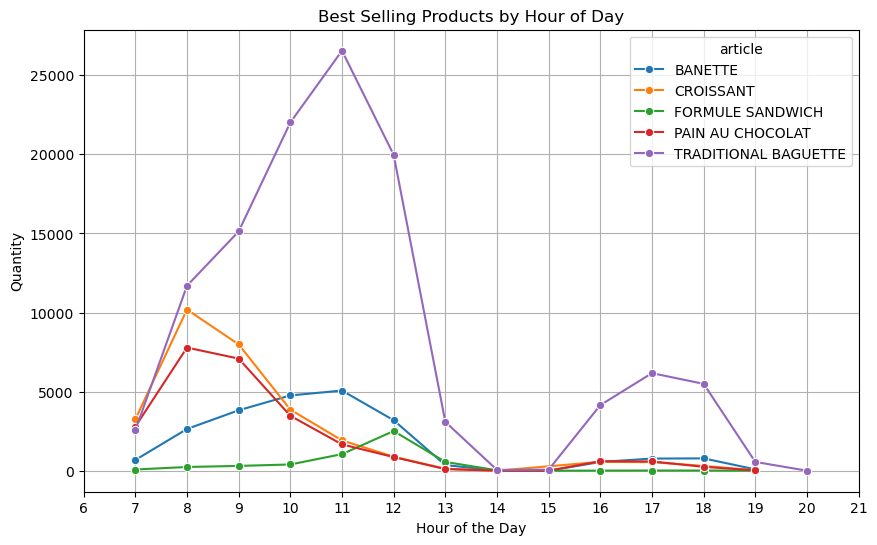

In [93]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=best_selling_hour, x='hour', y='quantity', marker='o', hue='article')
plt.title('Best Selling Products by Hour of Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Quantity')
plt.xticks(range(6, 22))
plt.grid(True)
plt.show()

## Analyzing Transactions

In [94]:
transaction_behavior = sales_data.groupby('ticket_number').agg({
    'quantity': 'sum',  
    'revenue': 'sum'
}).rename(columns={'quantity': 'total_items', 'revenue': 'transaction_value'}).reset_index()

transaction_behavior.head()

,ticket_number,total_items,transaction_value
0,150040.0,4.0,4.50
1,150041.0,3.0,3.55
2,150042.0,5.0,6.00
3,150043.0,5.0,5.10
4,150044.0,1.0,1.05


In [95]:
transaction_behavior.describe()

,ticket_number,total_items,transaction_value
count,134962.000000,134962.000000,134962.000000
mean,219328.223826,2.668588,4.142624
std,40119.859775,2.303218,4.412152
min,150040.000000,1.000000,0.000000
25%,184608.250000,1.000000,1.300000
50%,218924.500000,2.000000,2.550000
75%,254241.750000,3.000000,5.100000
max,288913.000000,87.000000,199.700000


In [96]:
transaction_behavior[transaction_behavior['transaction_value'] == 199.7]

,ticket_number,total_items,transaction_value
43198,194199.0,23.0,199.7


In [97]:
sales_data[sales_data['ticket_number'] == 194199.0]

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
74998,2021-07-31,0 days 12:32:00,194199.0,GRAND FAR BRETON,1.0,7.0,2021-07-31 12:32:00,7.0,2021-07,5,Saturday,12
74999,2021-07-31,0 days 12:32:00,194199.0,GD NANTAIS,11.0,11.0,2021-07-31 12:32:00,121.0,2021-07,5,Saturday,12
75000,2021-07-31,0 days 12:32:00,194199.0,GD KOUIGN AMANN,9.0,7.5,2021-07-31 12:32:00,67.5,2021-07,5,Saturday,12
75001,2021-07-31,0 days 12:32:00,194199.0,KOUIGN AMANN,2.0,2.1,2021-07-31 12:32:00,4.2,2021-07,5,Saturday,12


In [98]:
sales_data[sales_data['article'] == 'GD NANTAIS']

,date,time,ticket_number,article,quantity,unit_price,datetime,revenue,month,day_of_week,day_name,hour
74881,2021-07-31,0 days 11:25:00,194127.0,GD NANTAIS,1.0,11.0,2021-07-31 11:25:00,11.0,2021-07,5,Saturday,11
74999,2021-07-31,0 days 12:32:00,194199.0,GD NANTAIS,11.0,11.0,2021-07-31 12:32:00,121.0,2021-07,5,Saturday,12
75043,2021-07-31,0 days 16:19:00,194225.0,GD NANTAIS,1.0,11.0,2021-07-31 16:19:00,11.0,2021-07,5,Saturday,16
75653,2021-08-01,0 days 11:10:00,194545.0,GD NANTAIS,1.0,11.0,2021-08-01 11:10:00,11.0,2021-08,6,Sunday,11
77555,2021-08-04,0 days 11:36:00,195613.0,GD NANTAIS,1.0,11.0,2021-08-04 11:36:00,11.0,2021-08,2,Wednesday,11
...,...,...,...,...,...,...,...,...,...,...,...,...
167873,2022-05-13,0 days 09:05:00,249448.0,GD NANTAIS,1.0,12.0,2022-05-13 09:05:00,12.0,2022-05,4,Friday,9
168002,2022-05-13,0 days 11:44:00,249524.0,GD NANTAIS,1.0,12.0,2022-05-13 11:44:00,12.0,2022-05,4,Friday,11
168452,2022-05-14,0 days 18:39:00,249793.0,GD NANTAIS,1.0,12.0,2022-05-14 18:39:00,12.0,2022-05,5,Saturday,18
189057,2022-07-07,0 days 08:23:00,262388.0,GD NANTAIS,1.0,12.0,2022-07-07 08:23:00,12.0,2022-07,3,Thursday,8


## Most Popular Product Combinations

In [113]:
transactions = sales_data.groupby('ticket_number')['article'].apply(list)
#filtering single-product transactions
#transactions = transactions[transactions.apply(len) > 1]
transaction_list = transactions.tolist()

In [114]:
te = TransactionEncoder()
te_array = te.fit(transaction_list).transform(transaction_list)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

In [122]:
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

In [123]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_sorted = rules.sort_values(by="lift", ascending=False)

In [124]:
print(rules_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

                                 antecedents  \
20  (TRADITIONAL BAGUETTE, PAIN AU CHOCOLAT)   
23                               (CROISSANT)   
2                                    (COUPE)   
3                               (BOULE 200G)   
17                               (CROISSANT)   
16                        (PAIN AU CHOCOLAT)   
22                        (PAIN AU CHOCOLAT)   
21         (TRADITIONAL BAGUETTE, CROISSANT)   
7                                 (CAMPAGNE)   
6                                    (COUPE)   
5                               (BOULE 400G)   
4                                    (COUPE)   
8                                    (COUPE)   
9                                  (COMPLET)   
14                               (VIK BREAD)   
15                                   (COUPE)   
10                                   (COUPE)   
11                                 (MOISSON)   
12                                   (COUPE)   
13                           (SPECIAL BR

### Trying FpGrowth

In [126]:
frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)
rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1)
rules_fp_sorted = rules_fp.sort_values(by="lift", ascending=False)

In [127]:
rules_fp_sorted[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
2,"(TRADITIONAL BAGUETTE, PAIN AU CHOCOLAT)",(CROISSANT),0.016694,0.540029,6.429939
5,(CROISSANT),"(TRADITIONAL BAGUETTE, PAIN AU CHOCOLAT)",0.016694,0.198765,6.429939
11,(BOULE 200G),(COUPE),0.017538,0.889515,6.230577
10,(COUPE),(BOULE 200G),0.017538,0.122846,6.230577
1,(CROISSANT),(PAIN AU CHOCOLAT),0.039619,0.471725,6.101679
0,(PAIN AU CHOCOLAT),(CROISSANT),0.039619,0.512459,6.101679
3,"(TRADITIONAL BAGUETTE, CROISSANT)",(PAIN AU CHOCOLAT),0.016694,0.462249,5.979107
4,(PAIN AU CHOCOLAT),"(TRADITIONAL BAGUETTE, CROISSANT)",0.016694,0.215929,5.979107
15,(CAMPAGNE),(COUPE),0.022955,0.800103,5.604294
14,(COUPE),(CAMPAGNE),0.022955,0.160785,5.604294


## Experimenting

In [104]:

# Find combinations of products in each transaction
all_combinations = []
for products in transactions:
    all_combinations.extend(combinations(sorted(products), 2))  # Pairwise combinations

# Count occurrences of each combination
combination_counts = Counter(all_combinations)

# Convert to DataFrame for analysis
combo_df = pd.DataFrame(combination_counts.items(), columns=['product_pair', 'count'])
combo_df = combo_df.sort_values('count', ascending=False)

print(combo_df.head(10)) 

                                product_pair  count
23             (COUPE, TRADITIONAL BAGUETTE)   6430
4              (CROISSANT, PAIN AU CHOCOLAT)   5451
3          (CROISSANT, TRADITIONAL BAGUETTE)   4930
5   (PAIN AU CHOCOLAT, TRADITIONAL BAGUETTE)   4216
15                       (BOULE 400G, COUPE)   3446
17                         (CAMPAGNE, COUPE)   3380
8                     (COUPE, SPECIAL BREAD)   3321
80                        (COUPE, VIK BREAD)   2643
97                          (COMPLET, COUPE)   2597
12                       (BOULE 200G, COUPE)   2520
